# Big Data and Machine Learning CW1

imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import tensorflow as tf
from skimage.feature import hog
import sklearn.metrics
import matplotlib.patheffects as path_effects

load images and labels

In [27]:
trn_images = np.load('trnImage.npy')
trn_labelscoarse = np.load('trnLabel_coarse.npy')

tst_images = np.load('tstImage.npy')
tst_labelscoarse = np.load('tstLabel_coarse.npy')

#load the label names from the csv file
labelnamescoarse = np.genfromtxt('coarse_labels.csv', delimiter=',',
                                 dtype=None, encoding=None)

print(trn_images.shape)

(32, 32, 3, 50000)


try to load a single image and print its coarse label

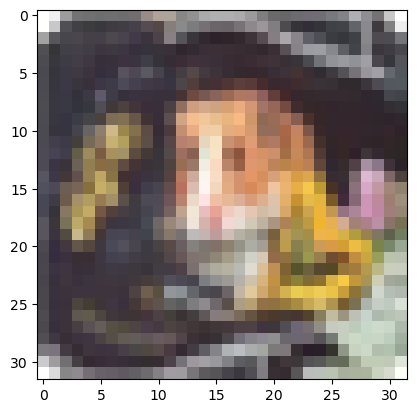

coarse label: small mammals


In [28]:
image_index = 784 # pick a specific image
image = trn_images[:, :, :, image_index]
#display the image
plt.imshow(image, cmap='gray')
plt.show()
#get the images coarse label index
labelcoarse = trn_labelscoarse[image_index]
#get the images coarse label name
labelcoarsename = labelnamescoarse[labelcoarse]
print('coarse label:',labelcoarsename)

# CNN

In [29]:
#transpose the data to be in the correct format (32, 32, 3, 50000) to (50000, 32, 32, 3)
trn_images = trn_images.transpose(3, 0, 1, 2)

# flatten the data
trn_images = trn_images.reshape(50000, 3072)

#normalise the data
trn_images = trn_images / 255.0

#reshape to be in the correct format for the model
trn_images = trn_images.reshape(50000, 32, 32, 3)

# clear the previous model
tf.keras.backend.clear_session()

# build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='softmax'))

#comile the model without a learning rate schedule
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [31]:
# train the model
model.fit(trn_images, trn_labelscoarse, epochs=24, batch_size=64)

Epoch 1/24
782/782 [==============================] - 14s 17ms/step - loss: 2.2095 - accuracy: 0.3218
Epoch 2/24
782/782 [==============================] - 13s 17ms/step - loss: 1.7693 - accuracy: 0.4466
Epoch 3/24
782/782 [==============================] - 13s 17ms/step - loss: 1.5336 - accuracy: 0.5164
Epoch 4/24
782/782 [==============================] - 13s 17ms/step - loss: 1.3287 - accuracy: 0.5806
Epoch 5/24
782/782 [==============================] - 14s 18ms/step - loss: 1.1560 - accuracy: 0.6305
Epoch 6/24
782/782 [==============================] - 13s 17ms/step - loss: 0.9591 - accuracy: 0.6890
Epoch 7/24
782/782 [==============================] - 13s 17ms/step - loss: 0.7815 - accuracy: 0.7457
Epoch 8/24
782/782 [==============================] - 13s 17ms/step - loss: 0.6333 - accuracy: 0.7909
Epoch 9/24
782/782 [==============================] - 13s 17ms/step - loss: 0.5010 - accuracy: 0.8336
Epoch 10/24
782/782 [==============================] - 13s 17ms/step - loss: 0.400

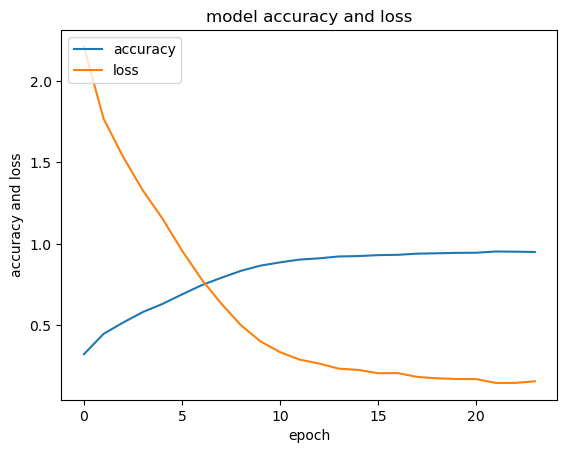

In [32]:
#plot the accuracy and loss over time
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

313/313 [==============================] - 2s 5ms/step
per label accuracy:
aquatic mammals : 0.002
fish : 0.006
flowers : 0.252
food containers : 0.04
fruit and vegetables : 0.172
household electrical devices : 0.436
household furniture : 0.394
insects : 0.026
large carnivores : 0.002
large man-made outdoor things : 0.018
large natural outdoor scenes : 0.002
large omnivores and herbivores : 0.01
medium-sized mammals : 0.046
non-insect invertebrates : 0.006
people : 0.088
reptiles : 0.0
small mammals : 0.0
trees : 0.034
vehicles 1 : 0.746
vehicles 2 : 0.05


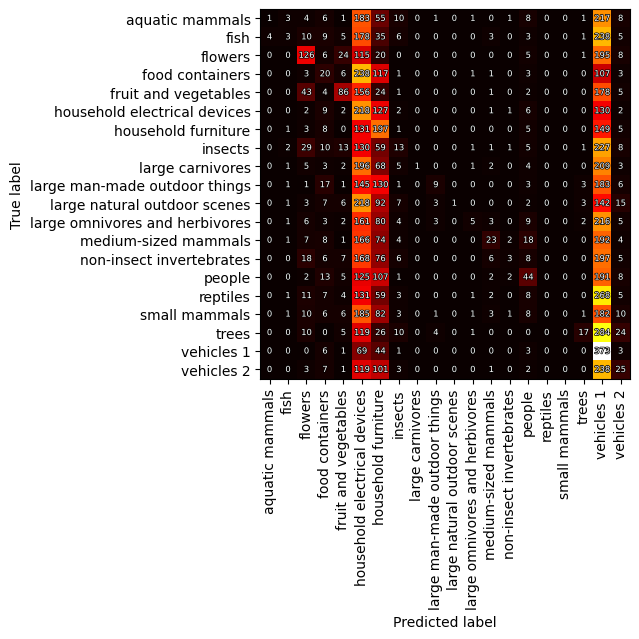

In [33]:
# Reshape the input data to have a depth of 3
tst_images_transposed = tst_images.transpose(3, 0, 1, 2)
tst_images_reshaped = tst_images_transposed.reshape(tst_images.shape[3], 32, 32, 3)

# Predict using the reshaped input data
predictions = model.predict(tst_images_reshaped)

# Compute the confusion matrix
predictions = np.argmax(predictions, axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(tst_labelscoarse, predictions)

#label the axes with the actual label names
plt.xticks(np.arange(20), labelnamescoarse, rotation=90)
plt.yticks(np.arange(20), labelnamescoarse)
plt.xlabel('Predicted label')
plt.ylabel('True label')


#plot the confusion matrix as a heatmap
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
for i in range(20):
    for j in range(20):
        text = plt.annotate(confusion_matrix[i][j], xy=(j, i),
                            horizontalalignment='center',
                            verticalalignment='center', color='white', fontsize=6)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                               path_effects.Normal()])

#print the per label accuracy
print('per label accuracy:')
for i in range(20):
    print(labelnamescoarse[i],':', confusion_matrix[i][i] / np.sum(confusion_matrix[i]))


In [34]:
#print the average accuracy for the model
print('average accuracy:', np.trace(confusion_matrix) / np.sum(confusion_matrix))

average accuracy: 0.1165


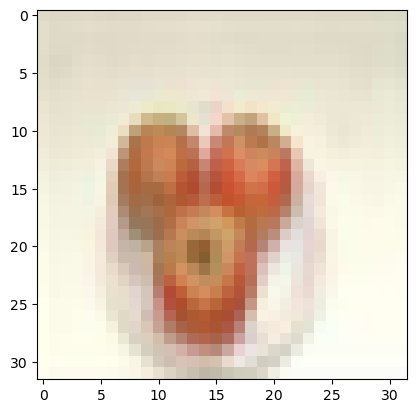

1/1 [==============================] - 0s 66ms/step
predicted label: household furniture
actual label: fruit and vegetables


In [35]:
#get an image from the test set
image_index = 6212
image = tst_images[:,:,:,image_index]

#display the image
plt.imshow(image, cmap='gray')
plt.show()

#reshape the image to be in the correct format for the model
image = image.reshape(1, 32, 32, 3)

#make a prediction on the image
prediction = model.predict(image)

#print the prediction names from the csv file
print('predicted label:',labelnamescoarse[np.argmax(prediction)])
print('actual label:',labelnamescoarse[tst_labelscoarse[image_index]])


# HOG Feature Extraction + FCNN

In [36]:
from sklearn.preprocessing import StandardScaler

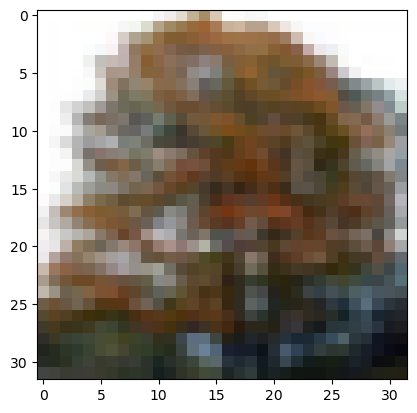

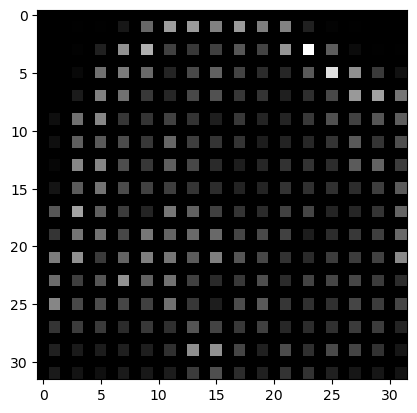

label: large natural outdoor scenes


In [37]:
#visualise a hog feature from the test set
image_index = 56
image = trn_images[image_index,:,:,:]
image = image*255
plt.imshow(image, cmap='gray')
plt.show()
hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[1,1], visualize=True, channel_axis=-1)
plt.imshow(hog_image, cmap='gray')
plt.show()
#print the label name from the csv file
print('label:',labelnamescoarse[tst_labelscoarse[image_index]])


In [38]:
print(trn_images.shape)

(50000, 32, 32, 3)


In [39]:
#get the hog features for the training set
trn_hog_features = np.zeros((50000, 2304))
for i in range(50000):
    trn_hog_features[i] = skimage.feature.hog(trn_images[i,:,:,:], pixels_per_cell=[2,2], cells_per_block=[1,1], visualize=False, channel_axis=-1)

In [40]:
#normalise the hog feature data
scaler = StandardScaler()
trn_hog_features = scaler.fit_transform(trn_hog_features)

In [41]:
#save the hog features
np.save('trn_hog_features.npy', trn_hog_features)

In [42]:
#load the hog features
trn_hog_features = np.load('trn_hog_features.npy')

In [43]:
#clear the previous model
tf.keras.backend.clear_session()

#build a fully connected model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(20, activation='softmax'))

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
#train the model
model.fit(trn_hog_features, trn_labelscoarse, epochs=24, batch_size=64)

Epoch 1/24
782/782 [==============================] - 9s 10ms/step - loss: 2.5261 - accuracy: 0.2312
Epoch 2/24
782/782 [==============================] - 7s 9ms/step - loss: 1.9465 - accuracy: 0.4013
Epoch 3/24
782/782 [==============================] - 6s 8ms/step - loss: 1.3467 - accuracy: 0.5780
Epoch 4/24
782/782 [==============================] - 6s 8ms/step - loss: 0.7111 - accuracy: 0.7786
Epoch 5/24
782/782 [==============================] - 6s 8ms/step - loss: 0.3234 - accuracy: 0.9004
Epoch 6/24
782/782 [==============================] - 6s 8ms/step - loss: 0.1937 - accuracy: 0.9398
Epoch 7/24
782/782 [==============================] - 6s 8ms/step - loss: 0.2265 - accuracy: 0.9252
Epoch 8/24
782/782 [==============================] - 7s 9ms/step - loss: 0.2332 - accuracy: 0.9228
Epoch 9/24
782/782 [==============================] - 6s 8ms/step - loss: 0.1928 - accuracy: 0.9369
Epoch 10/24
782/782 [==============================] - 6s 8ms/step - loss: 0.1500 - accuracy: 0.950

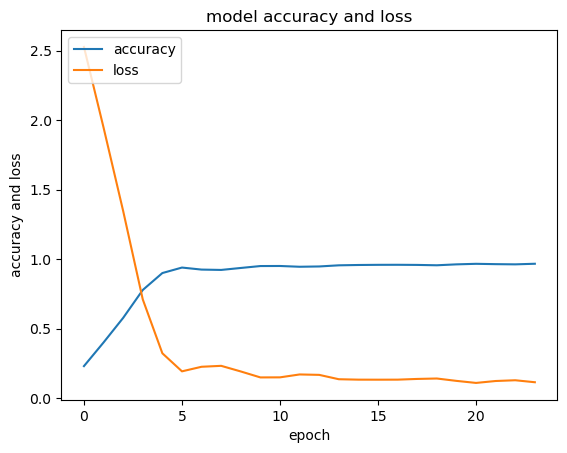

1563/1563 [==============================] - 6s 3ms/step
per label accuracy
aquatic mammals : 0.9364
fish : 0.978
flowers : 0.9668
food containers : 0.9612
fruit and vegetables : 0.98
household electrical devices : 0.976
household furniture : 0.9924
insects : 0.986
large carnivores : 0.9644
large man-made outdoor things : 0.984
large natural outdoor scenes : 0.9628
large omnivores and herbivores : 0.9692
medium-sized mammals : 0.9748
non-insect invertebrates : 0.9744
people : 0.9812
reptiles : 0.9836
small mammals : 0.9832
trees : 0.9724
vehicles 1 : 0.9792
vehicles 2 : 0.99


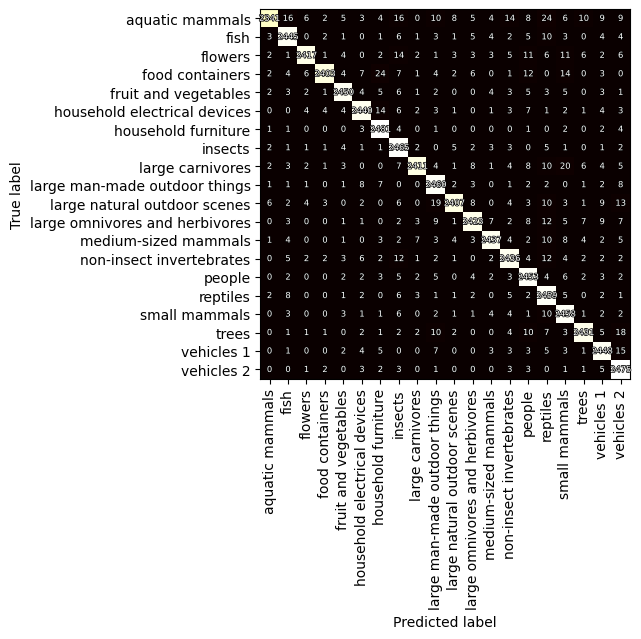

In [45]:
#plot the accuracy and loss over time
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy and loss')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

#show the confusion matrix
predictions = model.predict(trn_hog_features)
predictions = np.argmax(predictions, axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(trn_labelscoarse, predictions)
plt.xticks(np.arange(20), labelnamescoarse, rotation=90)
plt.yticks(np.arange(20), labelnamescoarse)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.imshow(confusion_matrix, cmap='hot', interpolation='nearest')
for i in range(20):
    for j in range(20):
        text = plt.annotate(confusion_matrix[i][j], xy=(j, i),
                            horizontalalignment='center',
                            verticalalignment='center', color='white', fontsize=6)
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                               path_effects.Normal()])
print('per label accuracy')
for i in range(20):
    print(labelnamescoarse[i],':', confusion_matrix[i][i] / np.sum(confusion_matrix[i]))


In [46]:
#print the average accuracy for the model
print('model accuracy:', np.sum(confusion_matrix.diagonal()) / np.sum(confusion_matrix))

model accuracy: 0.9748


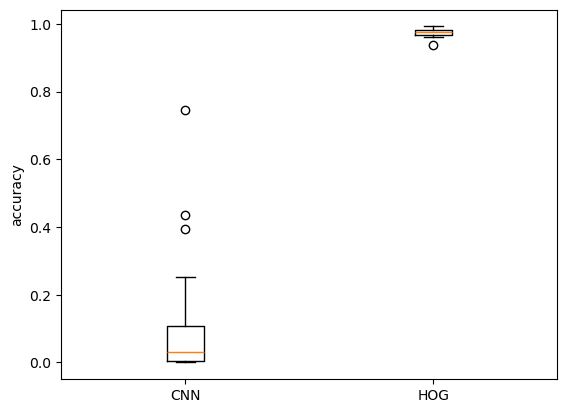

In [49]:
cnn_acc = [0.002, 0.006, 0.252, 0.04, 0.172, 0.436, 0.394, 0.026, 0.002, 0.018, 0.002, 0.01, 0.046, 0.006, 0.088, 0.0, 0.0, 0.034, 0.746, 0.05]
hog_acc = [0.9364, 0.978, 0.9668, 0.9612, 0.98, 0.976, 0.9924, 0.986, 0.9644, 0.984, 0.9628, 0.9692, 0.9748, 0.9744, 0.9812, 0.9836, 0.9832, 0.9724, 0.9792, 0.99]
#plot these two arrays as boxplots
plt.boxplot([cnn_acc, hog_acc], labels=['CNN', 'HOG'])
plt.ylabel('accuracy')
plt.show()

